In [1]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

import auxiliary_functions

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
import pandas as pd
df = pd.read_csv('../paper_data/socio_pat_primary_school/primaryschool.csv',
                 header=None, sep='\t', names=['time','id1','id2','class1','class2'])

In [3]:
df['hour'] = df['time'] // 3600
df['minute'] = (df['time'] % 3600) / 60

In [4]:
flag_teachers = (df['class1'] != 'Teachers') & (df['class2'] != 'Teachers')
flag_different_class = df['class1'] != df['class2']

df_students = df [flag_teachers].reset_index(drop=True)
flag_different_class_students = df_students['class1'] != df_students['class2']
flag_hetero_events = flag_different_class_students

In [5]:
# Initialize list to store non-consecutive interactions
non_consecutive_interactions = []

# Initialize list to store all unique interactions
unique_interactions = []

# Initialize counter for the number of unique time points from the perspective of interactions
counter_structures = 0

# Get the unique time values (order matters here, so ensure times are in the desired order)
unique_times = df_students['time'].unique()

# Iterate over the unique time points
for idx, time in enumerate(unique_times):
    # Filter the dataframe for the current time point
    current_df = df_students[df_students['time'] == time]
    
    # Create a set of interactions (as tuples) for the current time
    # Using tuples ensures each pair is unique and can be easily compared (row['id1'] is always < row['id1'])
    current_interactions = set((tuple([row['id1'], row['id2']])) for _, row in current_df.iterrows())
    
    if idx == 0:
        # For the first time point, initialize both non-consecutive and unique interactions
        non_consecutive_interactions.extend(current_interactions)
        unique_interactions.extend(current_interactions)
        # Increment the counter as this is the first structure
        counter_structures += 1
    else:
        # Find interactions that are new compared to the previous time point and add them
        new_interactions = current_interactions - previous_interactions
        non_consecutive_interactions.extend(new_interactions)
        
        # If there are new non-consecutive interactions, increment the counter
        if len(new_interactions) != 0:
            counter_structures += 1
        
        # Find interactions that are unique across all time points so far and add them
        truly_new_interactions = current_interactions - set(unique_interactions)
        unique_interactions.extend(truly_new_interactions)
    
    # Update previous_interactions to the current_interactions for the next iteration
    previous_interactions = current_interactions

# Output the results
print("Total number of non-consecutive interactions:", len(non_consecutive_interactions))
print("Total number of unique interactions:", len(unique_interactions))
print("Number of unique time points (from the interaction perspective):", counter_structures)


Total number of non-consecutive interactions: 73200
Total number of unique interactions: 7856
Number of unique time points (from the interaction perspective): 3099


In [6]:
df.to_csv('../paper_data/socio_pat_primary_school/primaryschool_hours.csv')
df_students[flag_hetero_events].to_csv('../paper_data/socio_pat_primary_school/primaryschool_hetero_events.csv')
print(df.shape)
print(df_students.shape)

(125773, 7)
(119517, 7)


In [7]:
df_students

,time,id1,id2,class1,class2,hour,minute
0,31220,1558,1567,3B,3B,8,40.333333
1,31220,1560,1570,3B,3B,8,40.333333
2,31220,1567,1574,3B,3B,8,40.333333
3,31220,1632,1818,4B,4B,8,40.333333
4,31220,1632,1866,4B,4B,8,40.333333
...,...,...,...,...,...,...,...
119512,148120,1752,1783,1A,1A,41,8.666667
119513,148120,1752,1789,1A,1A,41,8.666667
119514,148120,1775,1798,1A,1A,41,8.666667
119515,148120,1783,1796,1A,1A,41,8.666667


In [8]:
index_day1 = np.argmax(df_students['time'] / 3600 > 18)

minutes_bins_day1= int(np.ceil((df['time'][index_day1] - df_students['time'][0]) / 60))
minutes_bins_day2= int(np.ceil((df['time'][df.index[-1]]- df_students['time'][index_day1]) / 60))
print('number of necessary bins for day 1 = ' + str(minutes_bins_day1))
print('number of necessary bins for day 2 = ' + str(minutes_bins_day1))

index_day1_hetero_events = np.argmax(df_students[flag_hetero_events].reset_index()['time'] / 3600 > 18)
index_day1_homo_events = np.argmax(df_students[~flag_hetero_events].reset_index()['time'] / 3600 > 18)

number of necessary bins for day 1 = 480
number of necessary bins for day 2 = 480


In [9]:
print(index_day1)
print(index_day1_hetero_events)
print(index_day1_homo_events)

57782
14112
43670


In [10]:
df_students[flag_hetero_events].reset_index()['time'][index_day1_hetero_events:] / 3600 - 24

14112     8.700000
14113     8.738889
14114     8.744444
14115     8.744444
14116     8.744444
           ...    
28442    17.000000
28443    17.011111
28444    17.011111
28445    17.016667
28446    17.027778
Name: time, Length: 14335, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


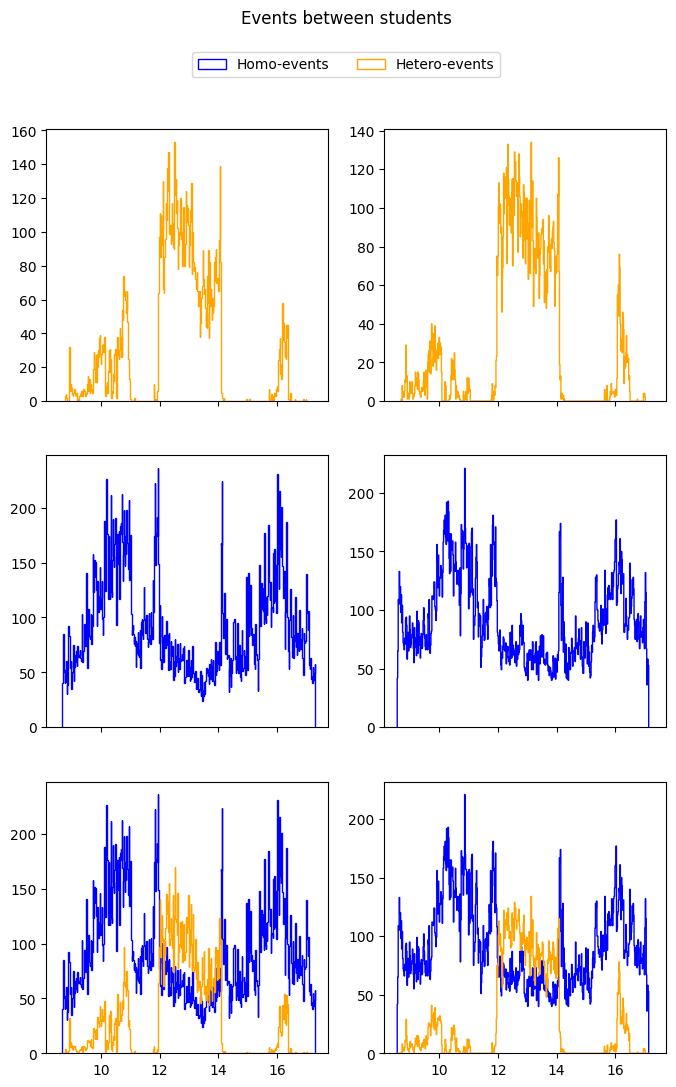

In [11]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(8, 12))

# Define colors
color_hetero = 'orange'
color_homo = 'blue'

# Hetero-Events
axs[0,0].hist(df_students[flag_hetero_events].reset_index()['time'][:index_day1_hetero_events] / 3600, bins=minutes_bins_day1, histtype='step', stacked=False, fill=False, color=color_hetero)
axs[0,1].hist(df_students[flag_hetero_events].reset_index()['time'][index_day1_hetero_events:] / 3600 - 24, bins=minutes_bins_day2, histtype='step', stacked=False, fill=False, color=color_hetero)

# Homo-Events
axs[1,0].hist(df_students[~flag_hetero_events].reset_index()['time'][:index_day1_homo_events] / 3600, bins=minutes_bins_day1, histtype='step', stacked=False, fill=False, color=color_homo)
axs[1,1].hist(df_students[~flag_hetero_events].reset_index()['time'][index_day1_homo_events:] / 3600 -24, bins=minutes_bins_day2, histtype='step', stacked=False, fill=False, color=color_homo)

# Combined histogram
axs[2,0].hist([df_students[flag_hetero_events].reset_index()['time'][:index_day1_hetero_events] / 3600, df_students[~flag_hetero_events].reset_index()['time'][:index_day1_homo_events] / 3600], bins=minutes_bins_day1, histtype='step', stacked=False, fill=False, color=[color_hetero, color_homo])
axs[2,1].hist([df_students[flag_hetero_events].reset_index()['time'][index_day1_hetero_events:] / 3600 -24, df_students[~flag_hetero_events].reset_index()['time'][index_day1_homo_events:] / 3600 -24], bins=minutes_bins_day2, histtype='step', stacked=False, fill=False, color=[color_hetero, color_homo], label = ['Hetero-events', 'Homo-events'])

# Add a shared legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
fig.suptitle('Events between students')
plt.savefig('/home/b/skoove/Desktop/primary_school/homo_hetero_global.eps', format='eps', dpi=300)
plt.show()

In [12]:
dict_flags_class = {}
classes = [1, 2, 3, 4, 5]
sections = ['A', 'B']
list_classes = []
for i in classes:
    for j in sections:
        flag = ((df_students['class1'] == f'{i}{j}') | (df_students['class2'] == f'{i}{j}'))
        dict_flags_class[f'flag{i}{j}'] = flag
        list_classes.append(f'{i}{j}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


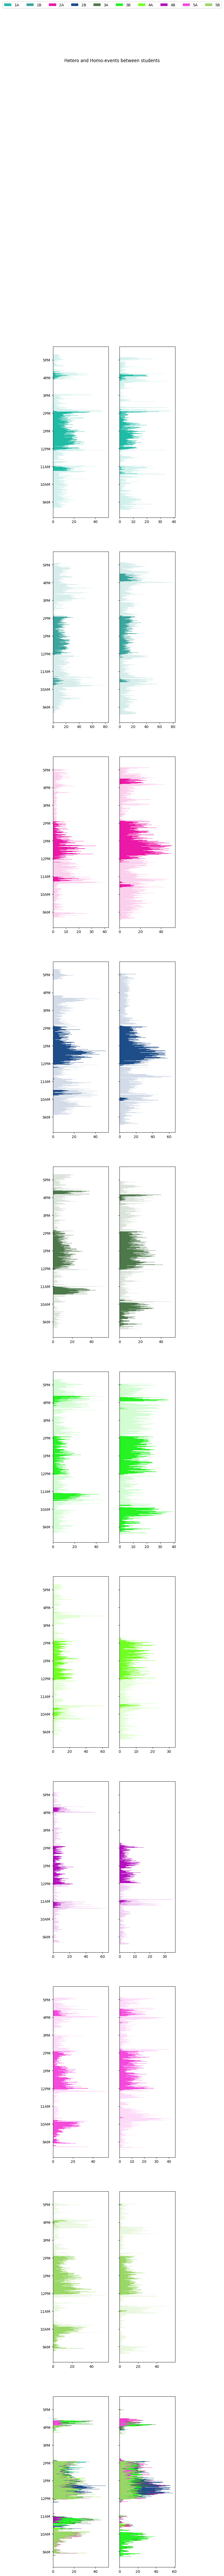

In [13]:
number_hetero_plots =len(list(dict_flags_class.keys())) +1 

yticks_positions = [9, 10, 11, 12, 13, 14, 15, 16, 17]  # Example positions, adjust as needed
yticks_labels = ['9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM']

fig, axs = plt.subplots(number_hetero_plots, 2, sharey=True, figsize=(6, 10 * number_hetero_plots))

# Define colors
# Generate 10 random colors
random_colors = auxiliary_functions.generate_random_colors(number_hetero_plots-1)


for i, flagkey in enumerate(list(dict_flags_class.keys())):
    df_class = df_students[dict_flags_class[flagkey]]
    flag_hetero_events = df_class['class1'] != df_class['class2']
    index_day1_hetero_events_class = np.argmax(df_class[flag_hetero_events].reset_index()['time'] / 3600 > 18)
    index_day1_homo_events_class = np.argmax(df_class[~flag_hetero_events].reset_index()['time'] / 3600 > 18)
    
    axs[i,0].hist(df_class[flag_hetero_events]['time'][:index_day1_hetero_events_class] / 3600, bins = minutes_bins_day1, color=random_colors[i], orientation = 'horizontal')
    axs[i,0].hist(df_class[~flag_hetero_events]['time'][:index_day1_homo_events_class] / 3600, bins = minutes_bins_day1, color=random_colors[i], orientation = 'horizontal', alpha = 0.2)
    # Set y-axis ticks
    axs[i,0].set_yticks(yticks_positions)
    axs[i,0].set_yticklabels(yticks_labels)
    
    axs[i,1].hist(df_class[flag_hetero_events]['time'][index_day1_hetero_events_class:] / 3600 -24, bins = minutes_bins_day2, color=random_colors[i], orientation = 'horizontal')
    axs[i,1].hist(df_class[~flag_hetero_events]['time'][index_day1_homo_events_class:] / 3600 -24, bins = minutes_bins_day2, color=random_colors[i], orientation = 'horizontal', alpha = 0.2)
    # Set y-axis ticks
    axs[i,1].set_yticks(yticks_positions)
    axs[i,1].set_yticklabels(yticks_labels)
    
    axs[number_hetero_plots-1,0].hist(df_class[flag_hetero_events]['time'][:index_day1_hetero_events_class] / 3600, bins = minutes_bins_day1, color=random_colors[i], orientation = 'horizontal')
    axs[number_hetero_plots-1,1].hist(df_class[flag_hetero_events]['time'][index_day1_hetero_events_class:] / 3600 -24, bins = minutes_bins_day2, color=random_colors[i], orientation = 'horizontal', label=list_classes[i])


axs[number_hetero_plots-1,0].set_yticks(yticks_positions)
axs[number_hetero_plots-1,0].set_yticklabels(yticks_labels)
axs[number_hetero_plots-1,1].set_yticks(yticks_positions)
axs[number_hetero_plots-1,1].set_yticklabels(yticks_labels)

# Add a shared legend
fig.legend(loc='upper center', ncol=len(list_classes))
fig.suptitle('Hetero and Homo-events between students')
plt.savefig('/home/b/skoove/Desktop/primary_school/homo_hetero_classes.eps', format='eps', dpi=300)
plt.show()

In [14]:
for i, flagkey in enumerate(list(dict_flags_class.keys())):
    df_class = df_students[dict_flags_class[flagkey]].reset_index(drop=True)
    #hetero events where the class under study is displayed under 'class1'
    flag_hetero_events_class1 = (df_class['class1'] == list_classes[i]) & (df_class['class2'] != list_classes[i])

    index_day1_hetero_events_class = np.argmax(df_class[flag_hetero_events_class1].reset_index()['time'] / 3600 > 18)
    print(index_day1_hetero_events_class)

976
2661
1644
1028
698
1910
1114
222
1305
2554


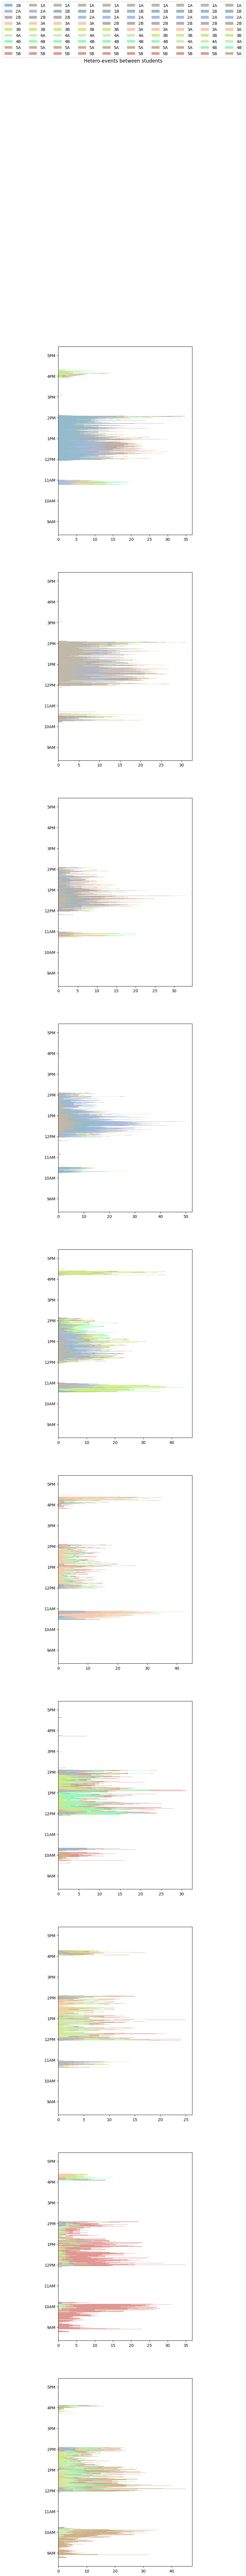

In [15]:
number_hetero_plots =len(list(dict_flags_class.keys()))

yticks_positions = [9, 10, 11, 12, 13, 14, 15, 16, 17]  # Example positions, adjust as needed
yticks_labels = ['9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM']

fig, axs = plt.subplots(number_hetero_plots, 1, sharey=True, figsize=(6, 10 * number_hetero_plots))

# Define colors
# Generate 10 random colors
random_colors = auxiliary_functions.generate_random_colors(number_hetero_plots)


for i, flagkey in enumerate(list(dict_flags_class.keys())):
    df_class = df_students[dict_flags_class[flagkey]].reset_index(drop=True)
    #hetero events where the class under study is displayed under 'class1'
    flag_hetero_events_class1 = (df_class['class1'] == list_classes[i]) & (df_class['class2'] != list_classes[i])
    flag_hetero_events_class2 = (df_class['class1'] != list_classes[i]) & (df_class['class2'] == list_classes[i])
    flag_hetero_evetns_classi = flag_hetero_events_class1 | flag_hetero_events_class2

    list_hetero_events_classi = []

    df_hetero_events_classi = df_class[flag_hetero_evetns_classi].reset_index(drop=True)
    
    for j in list_classes:
        if j != list_classes[i]:
            flag_classj = (df_hetero_events_classi['class1'] == j) | (df_hetero_events_classi['class2'] == j)
            index_day1_hetero_events_ij = np.argmax(df_hetero_events_classi[flag_classj].reset_index(drop=True)['time'] / 3600 > 18)
            list_hetero_events_classi.append(df_hetero_events_classi[flag_classj].reset_index(drop=True)['time'][:index_day1_hetero_events_ij] / 3600 )

    colors_classes = random_colors[:]
    colors_classes.remove(random_colors[i])

    copy_list_classes = list_classes[:]
    copy_list_classes.remove(list_classes[i])

    axs[i].hist(list_hetero_events_classi, bins = minutes_bins_day1, stacked=True, color=colors_classes, orientation = 'horizontal', alpha = 0.5, label=copy_list_classes)
    # Set y-axis ticks
    axs[i].set_yticks(yticks_positions)
    axs[i].set_yticklabels(yticks_labels)
    


    
    #axs[number_hetero_plots-1].hist(df_class[flag_hetero_events_class1]['time'][:index_day1_hetero_events_class1] / 3600, bins = minutes_bins_day1, color=random_colors[i], orientation = 'horizontal')



#axs[number_hetero_plots-1].set_yticks(yticks_positions)
#axs[number_hetero_plots-1].set_yticklabels(yticks_labels)

# Add a shared legend
fig.legend(loc='upper center', ncol=len(list_classes))
fig.suptitle('Hetero-events between students')
plt.show()

In [16]:
len(list_hetero_events_classi)

9

In [18]:
color = plt.cm.rainbow(np.linspace(0, 1, number_hetero_plots))

In [19]:
color

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.80392157e-01, 3.38158275e-01, 9.85162233e-01, 1.00000000e+00],
       [6.07843137e-02, 6.36474236e-01, 9.41089253e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [3.86274510e-01, 9.84086337e-01, 7.67362681e-01, 1.00000000e+00],
       [6.13725490e-01, 9.84086337e-01, 6.41213315e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 6.36474236e-01, 3.38158275e-01, 1.00000000e+00],
       [1.00000000e+00, 3.38158275e-01, 1.71625679e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

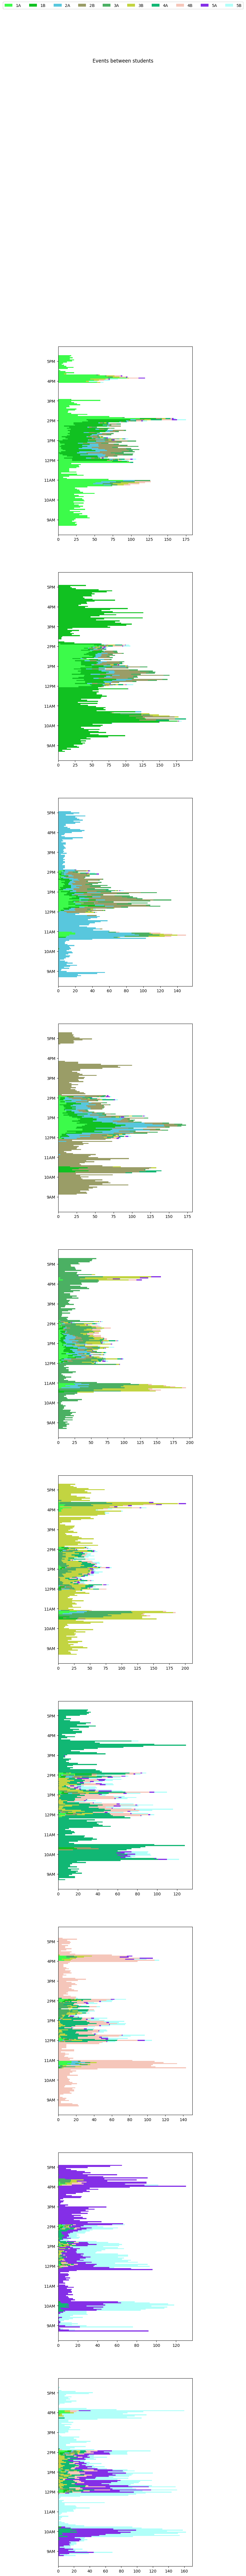

In [22]:
number_hetero_plots =len(list(dict_flags_class.keys()))

yticks_positions = [9, 10, 11, 12, 13, 14, 15, 16, 17]  # Example positions, adjust as needed
yticks_labels = ['9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM']

fig, axs = plt.subplots(number_hetero_plots, 1, sharey=True, figsize=(6, 10 * number_hetero_plots))

# Define colors
# Generate 10 random colors
random_colors = auxiliary_functions.generate_random_colors(number_hetero_plots)


for i, flagkey in enumerate(list(dict_flags_class.keys())):
    df_class = df_students[dict_flags_class[flagkey]].reset_index(drop=True)
    #hetero events where the class under study is displayed under 'class1'
    flag_hetero_events_class1 = (df_class['class1'] == list_classes[i]) & (df_class['class2'] != list_classes[i])
    flag_hetero_events_class2 = (df_class['class1'] != list_classes[i]) & (df_class['class2'] == list_classes[i])
    flag_hetero_events_classi = flag_hetero_events_class1 | flag_hetero_events_class2

    list_hetero_events_classi = []

    df_hetero_events_classi = df_class[flag_hetero_events_classi].reset_index(drop=True)
    
    for j in list_classes:
        if j != list_classes[i]:
            flag_classj = (df_hetero_events_classi['class1'] == j) | (df_hetero_events_classi['class2'] == j)
            index_day1_hetero_events_ij = np.argmax(df_hetero_events_classi[flag_classj].reset_index(drop=True)['time'] / 3600 > 18)
            list_hetero_events_classi.append(df_hetero_events_classi[flag_classj].reset_index(drop=True)['time'][:index_day1_hetero_events_ij] / 3600 )

    index_day1_hetero_events_i = np.argmax(df_class[~flag_hetero_events_classi].reset_index(drop=True)['time'] / 3600 > 18)
    list_hetero_events_classi.insert(i, df_class[~flag_hetero_events_classi].reset_index(drop=True)[:index_day1_hetero_events_i]['time'] / 3600)
    
    colors_classes = random_colors[:]
    colors_classes.remove(random_colors[i])

    copy_list_classes = list_classes[:]
    copy_list_classes.remove(list_classes[i])

    if i == 0:
        axs[i].hist(list_hetero_events_classi, bins = minutes_bins_day1 // 3, stacked=True, color=random_colors, orientation = 'horizontal', alpha = 1, label=list_classes)
    else:
        axs[i].hist(list_hetero_events_classi, bins = minutes_bins_day1 // 3, stacked=True, color=random_colors, orientation = 'horizontal', alpha = 1)
    # Set y-axis ticks
    axs[i].set_yticks(yticks_positions)
    axs[i].set_yticklabels(yticks_labels)
    


# Add a shared legend
fig.legend(loc='upper center', ncol=len(list_classes))
fig.suptitle('Events between students')
plt.show()